In [1]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import argparse
import os
import tempfile

from network import NAF
from sound_loader import sound_samples

import torch
import torch.optim as optim
import math
from torch.utils.data import DataLoader
import datetime

from modules import embedding_module_log

## CHECK IF SOUND_LOADER WORKS AS EXPECTED

Loading dataset. It might take a while ...
(200000,) (200000,) (200000,)


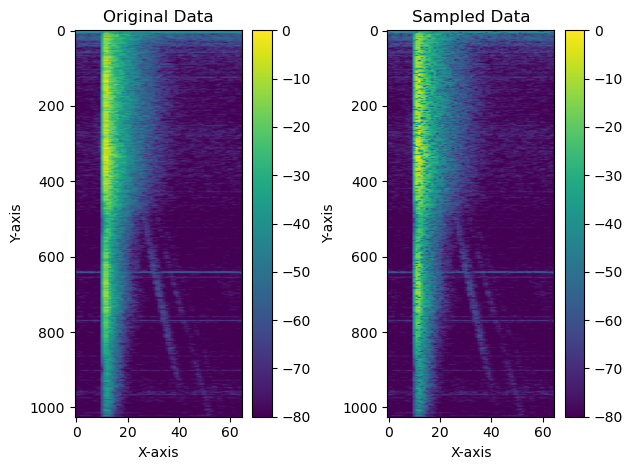

In [2]:
config_file = "saved/net_20230801_121113_loss_0.0422.pth"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset
print('Loading dataset. It might take a while ...')
dataset = sound_samples(num_samples=200000)

gts, src_norm, mic_norm, freqs_norm, times_norm, spectrogram = dataset.test(30)
freqs = (freqs_norm * 1025).astype(int)
times = (times_norm * 65).astype(int)
print(gts.shape, freqs.shape, times.shape)

# Generate some example data (replace this with your actual data)
original_data = spectrogram
sampled_data = np.full((1025,65), -80)

for i, f in enumerate(freqs):
    sampled_data[f, times[i]] = gts[i]

# Plot the original data as heatmap
plt.subplot(1, 2, 1)
plt.imshow(original_data, cmap='viridis', aspect='auto')
plt.title('Original Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar()

# Plot the sampled data as heatmap
plt.subplot(1, 2, 2)
plt.imshow(sampled_data, cmap='viridis', aspect='auto')
plt.title('Sampled Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


## CHECK IF GRID IS GENERATED CORRECTLY

Loading dataset. It might take a while ...
[0, 0] [1, 1]


,0,1
0,-1.00,-1.00
1,-0.85,-1.00
2,-0.70,-1.00
3,-0.55,-1.00
4,-0.40,-1.00
...,...,...
191,0.35,0.95
192,0.50,0.95
193,0.65,0.95
194,0.80,0.95


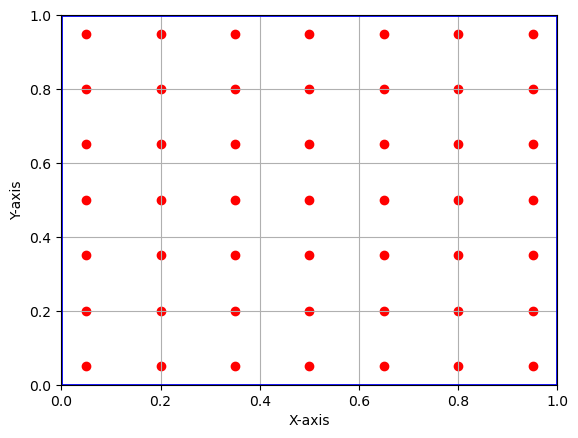

In [3]:
# Device selection
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Trainig parameters
learning_rate = 0.001
num_epochs = 200
batch_size = 20# Example coordinates
max_xy = np.array([10, 15])
min_xy = np.array([0, 0])

# Example grid coordinates (replace this with your actual data)
grid_coords_xy = np.array([[1, 1], [2, 3], [4, 5], [8, 13]])

ft_num = 2000

# Dataset
print('Loading dataset. It might take a while ...')
dataset = sound_samples(num_samples=ft_num)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Spawn embedders and move to GPU
xyz_embedder = embedding_module_log(num_freqs=7, ch_dim=2, max_freq=7).to(device)
freq_embedder = embedding_module_log(num_freqs=7, ch_dim=2).to(device)
time_embedder = embedding_module_log(num_freqs=7, ch_dim=2).to(device)

# Spawn network and move to GPU
net = NAF(input_dim = 248, min_xy=dataset.min_pos[:2], max_xy=dataset.max_pos[:2]).to(device)

min_xy = [0,0]
max_xy = [1,1]
grid = net.grid_coords_xy.cpu()

print(min_xy, max_xy)
df = pd.DataFrame(grid)
display(df)
# Plot the Cartesian plane and the grid coordinates
plt.figure()

# Plot the square delimited by max_xy and min_xy
plt.plot([min_xy[0], max_xy[0], max_xy[0], min_xy[0], min_xy[0]],
         [min_xy[1], min_xy[1], max_xy[1], max_xy[1], min_xy[1]],
         color='b', linestyle='-', linewidth=2)

# Plot the grid coordinates
for point in grid:
    plt.scatter(point[0], point[1], color='r', marker='o', label='Grid Coordinates')

# Set axis limits
plt.xlim(min_xy[0], max_xy[0])
plt.ylim(min_xy[1], max_xy[1])

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.grid()
plt.show()

# CHECKING POSITONAL ENCODING

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
xyz_embedder = embedding_module_log(num_freqs=7, ch_dim=0, max_freq=7).to(device)
vec = torch.rand(3).mul_(2).sub_(1).to(device)
print(vec)
output = xyz_embedder(vec).cpu()
df = pd.DataFrame(output)
display(output)

tensor([-0.4794,  0.4359, -0.0841], device='cuda:0')


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.